In [1]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
with open('data-jan-2022.json') as file:
    data = json.load(file)
values = data['result'][0]['values']
data = pd.DataFrame(values, columns=['timestamp', 'cpu_usage'])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data['cpu_usage'] = pd.to_numeric(data['cpu_usage'])
data.set_index('timestamp', inplace=True)

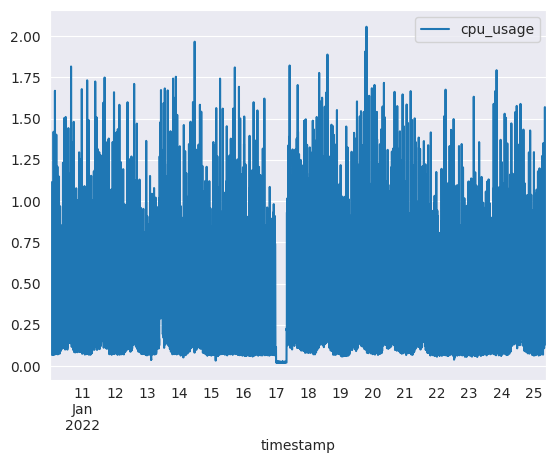

In [3]:
data.plot(y="cpu_usage")
plt.show()


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4435 entries, 2022-01-10 00:05:00 to 2022-01-25 09:35:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cpu_usage  4435 non-null   float64
dtypes: float64(1)
memory usage: 69.3 KB


Данные представляют собой временной ряд с непрерывно записанными значениями загрузки CPU (`cpu_usage`), при этом данные полные (не содержат пропусков) и структурированы в формате `float64`. Это подходящий тип данных для анализа временных рядов или построения визуализаций.


In [5]:
data.describe()

,cpu_usage
count,4435.000000
mean,0.348625
std,0.379217
min,0.020857
25%,0.094286
50%,0.192229
75%,0.379229
max,2.056800


- CPU в среднем загружается на 35%, при этом большая часть времени загрузка достаточно низка (около 19–38%).
- Наблюдается редкое высокое использование (до 205%), что может быть аномалией и требует проверки.
- Распределение данных, скорее всего, имеет положительный перекос (асимметрия), так как среднее значение больше медианы, а максимальное значение значительно превышает квартильные пороговые значения.

# EDA

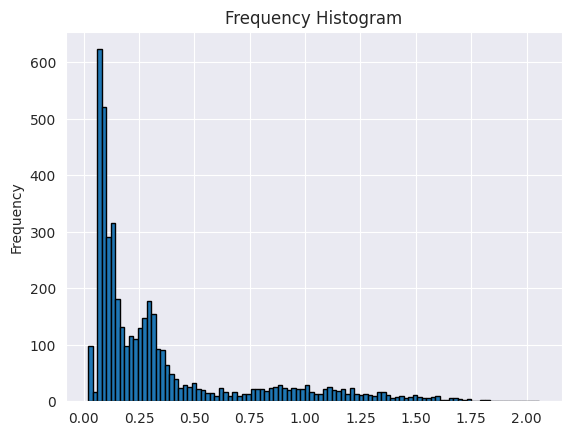

In [6]:
plt.hist(data, bins=100, density=False, edgecolor='black')
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

- Большая плотность значений использования CPU в диапазоне **от 0.03 до ~0.4** с постепенным спадом по мере увеличения значений.
- Продолжительный правый хвост, указывающий на редкие, но значительные всплески загрузки CPU


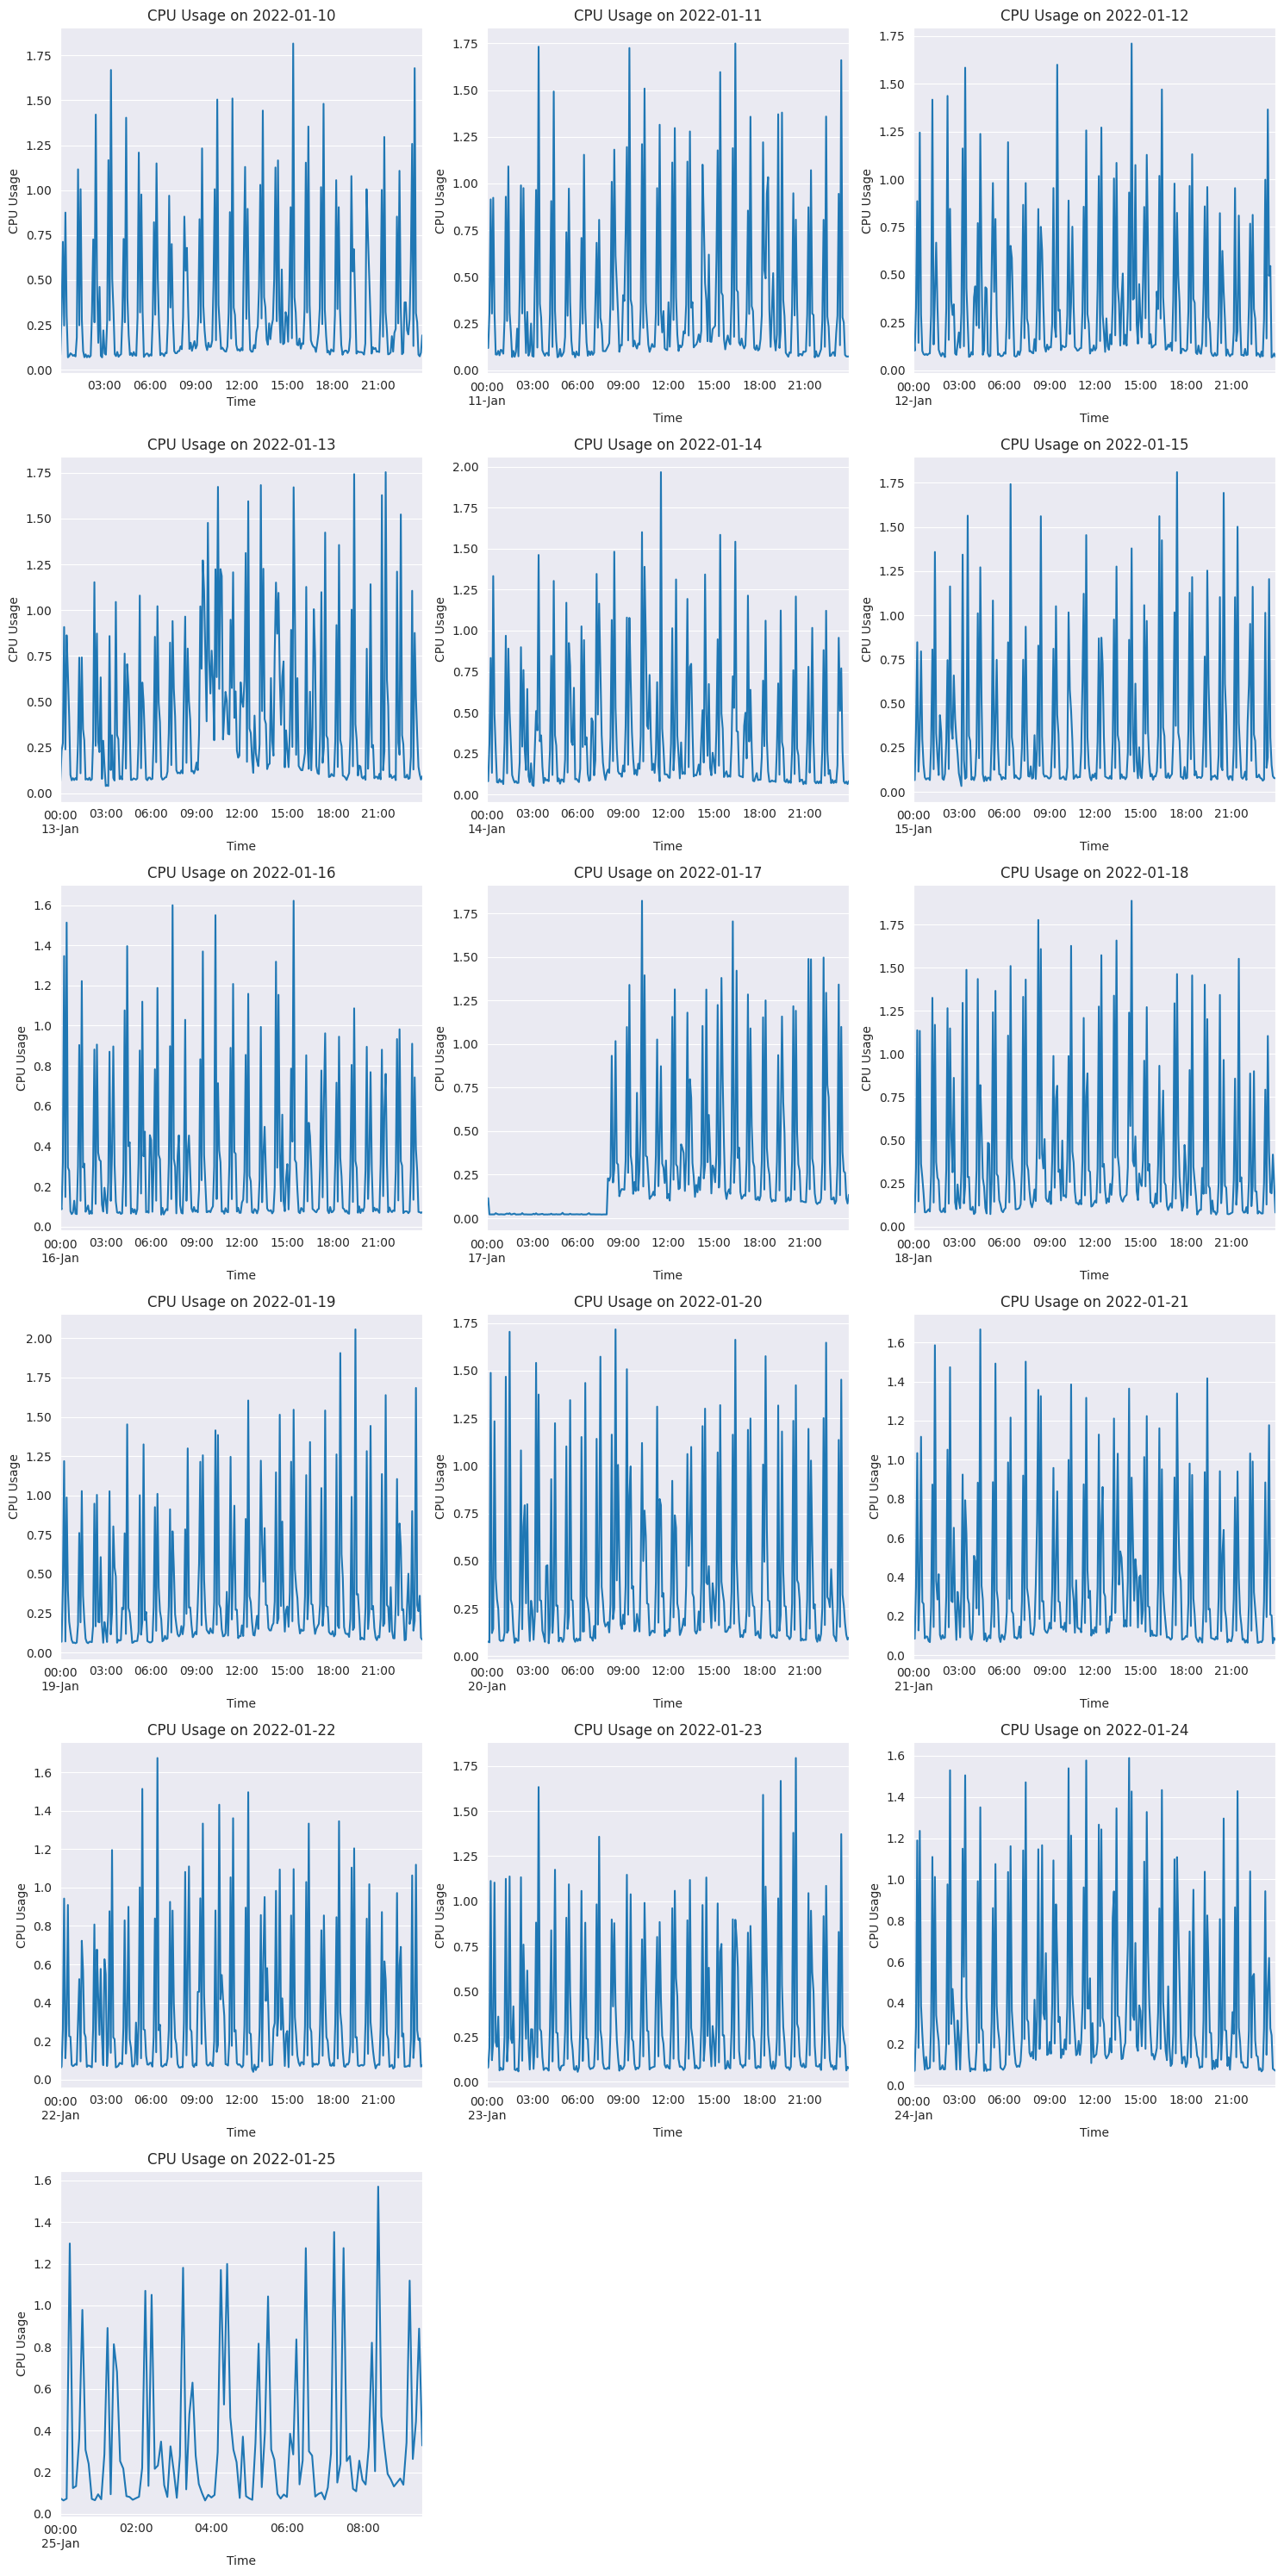

In [7]:
import math


# Group data by the date part of the index
groups = data.groupby(data.index.date)

# Set number of plots per row
plots_per_row = 3

# Create subplots
num_plots = len(groups)
num_rows = math.ceil(num_plots / plots_per_row)
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 5), squeeze=False)

# Plot each day's data
for ax, (date, group) in zip(axes.flat, groups):
    group.plot(y="cpu_usage", ax=ax, title=f'CPU Usage on {date}', legend=False)
    ax.set_xlabel('Time')
    ax.set_ylabel('CPU Usage')

# Hide any unused subplots if necessary
for ax in axes.flat[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [8]:
last_day = data.loc["2022-01-25"]
data.drop(last_day.index, inplace=True)

* Отбросим последний неполный день

In [9]:
weekday_data = data[data.index.weekday < 5].copy()

gap_start = '2022-01-17 00:00:00'
gap_end = '2022-01-17 08:00:00'

weekday_data['time'] = weekday_data.index.time
mean_usage_by_time = weekday_data.groupby('time')['cpu_usage'].mean()

gap_index = pd.date_range(start=gap_start, end=gap_end, freq='5min')
gap_times = gap_index.time

filled_values = [mean_usage_by_time[time] for time in gap_times]
data.loc[gap_index, 'cpu_usage'] = filled_values

weekday_data.drop(columns=['time'], inplace=True)

* Скорректируем данные: заполним пропущенные значения 17 января с 00:00 по 8:00 усредненными значениями будничных дней

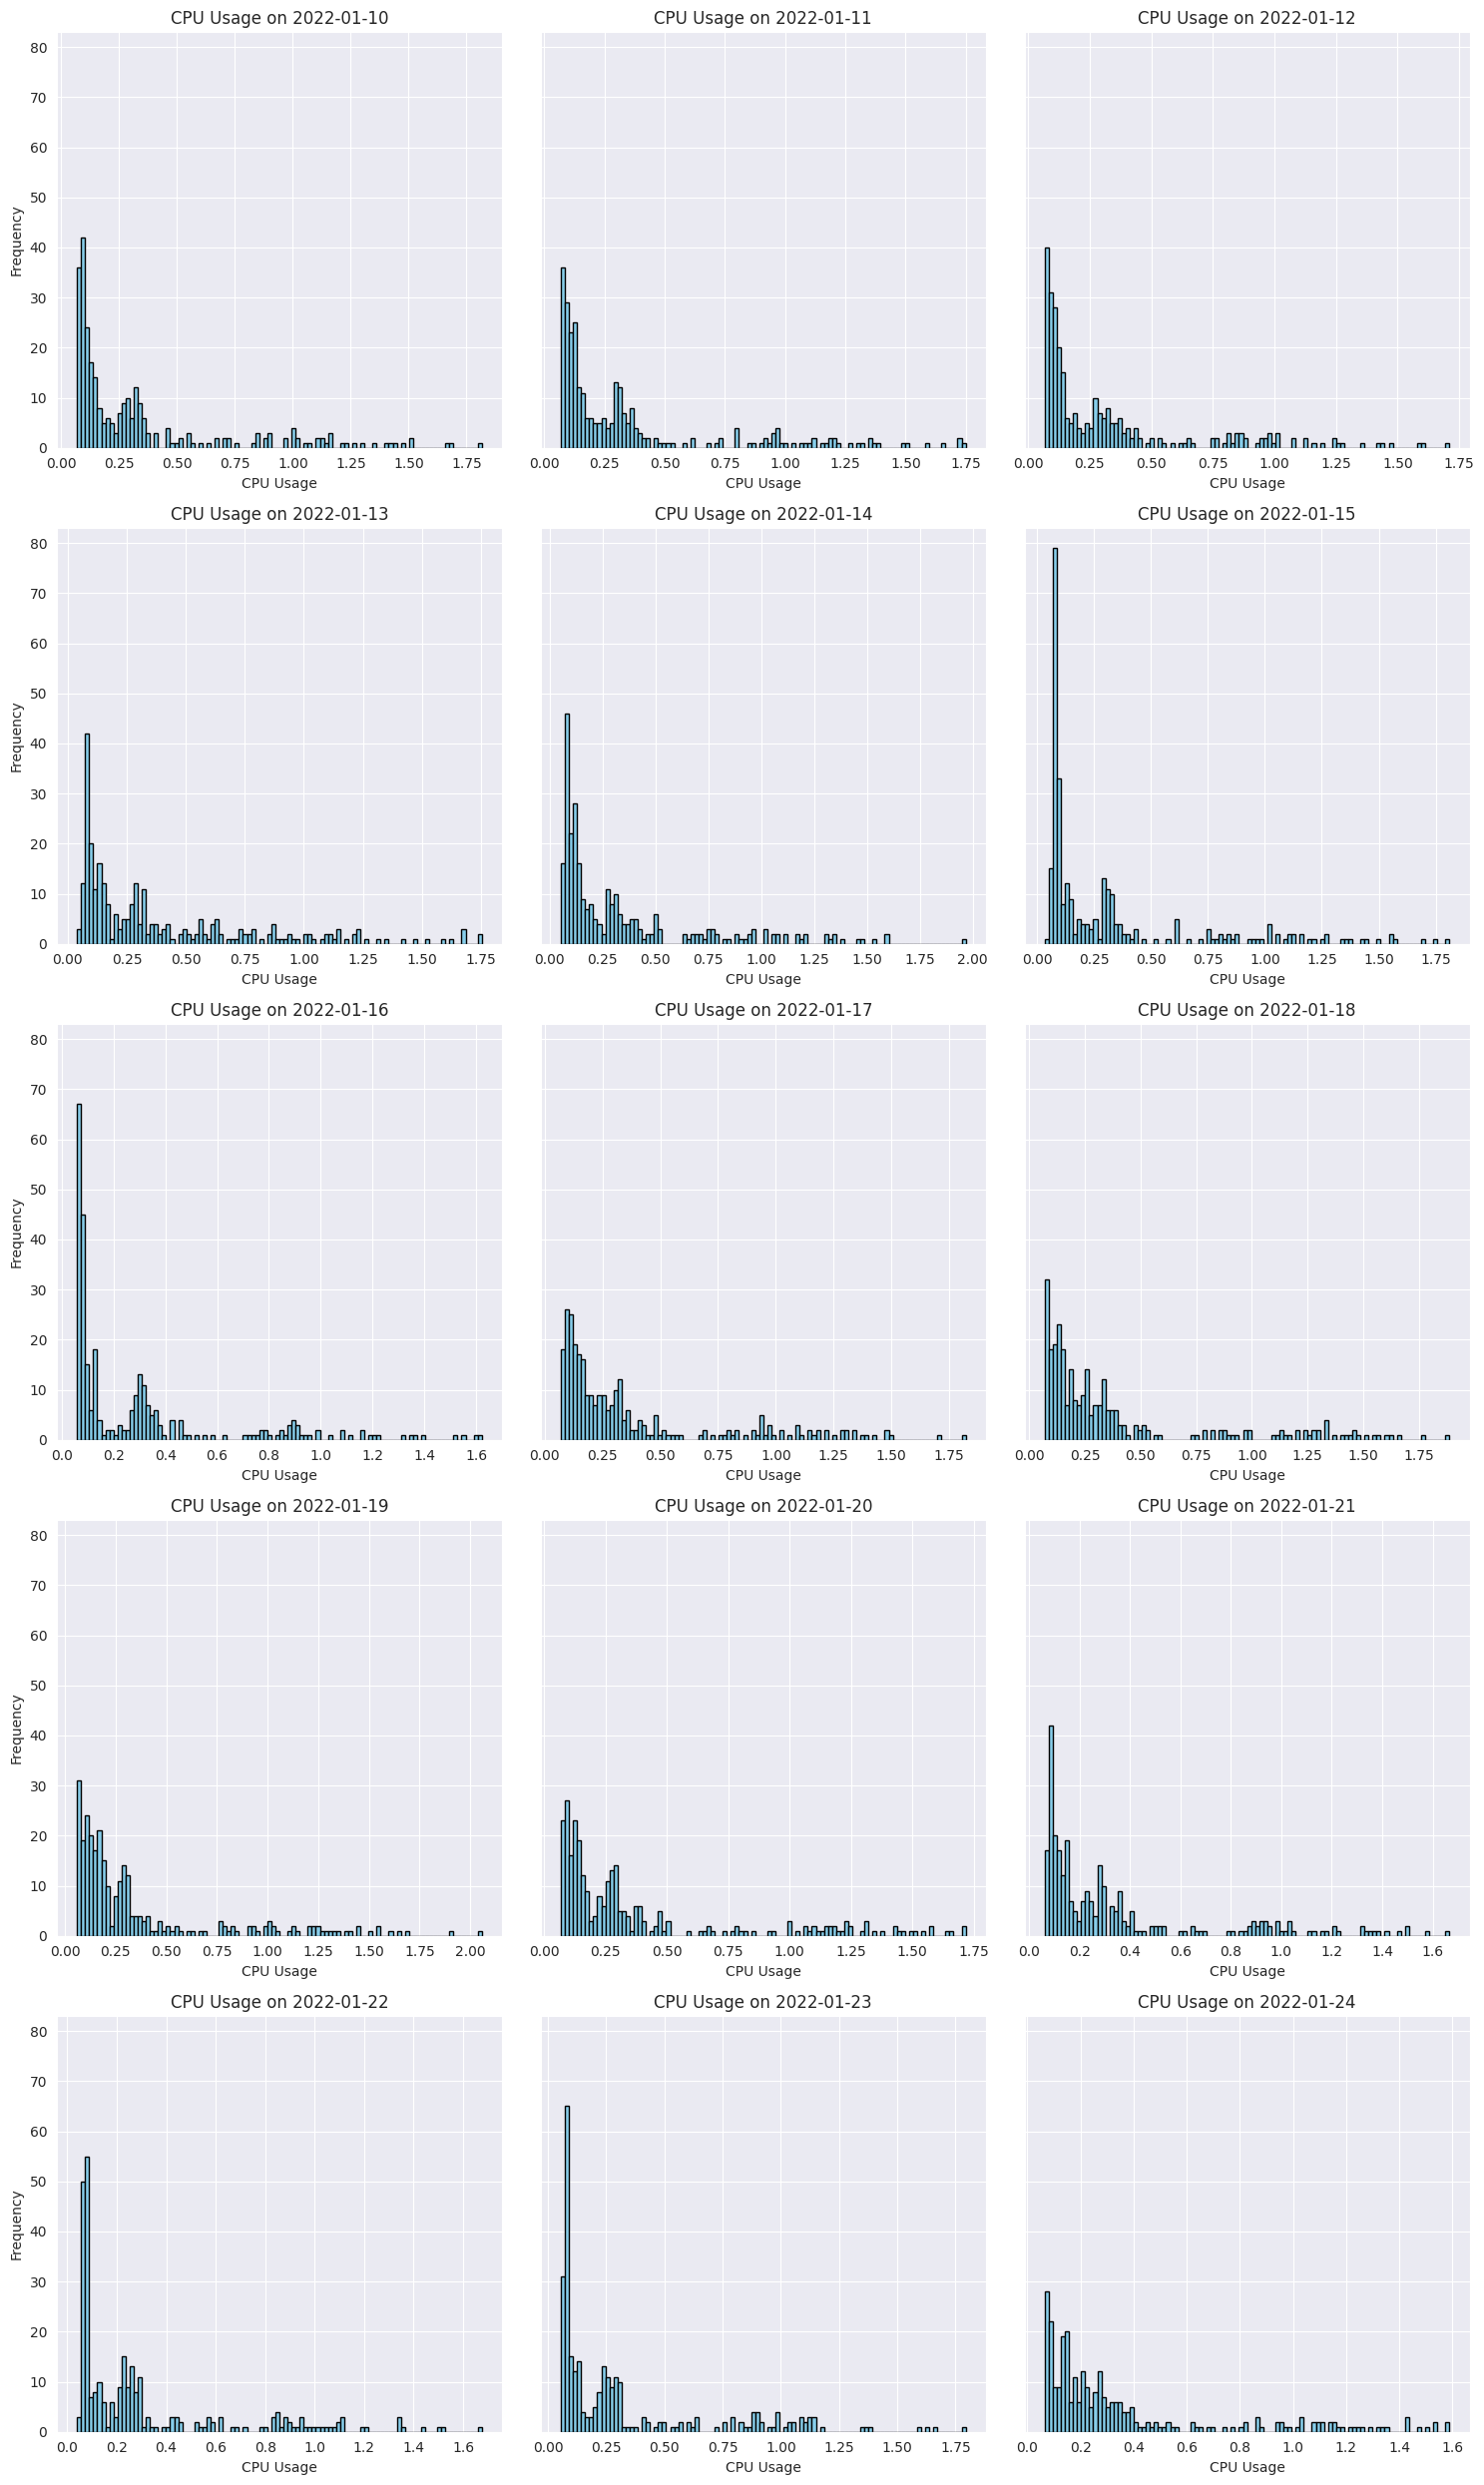

In [10]:
import math

groups = data.groupby(data.index.date)

plots_per_row = 3

num_plots = len(groups)
num_rows = math.ceil(num_plots / plots_per_row)
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 5), squeeze=False, sharey=True)

for ax, (date, group) in zip(axes.flat, groups):
    group.plot(y="cpu_usage", kind="hist", bins=100, ax=ax, color='skyblue', edgecolor='black', legend=False)
    ax.set_title(f'CPU Usage on {date}')
    ax.set_xlabel('CPU Usage')
    ax.set_ylabel('Frequency')

for ax in axes.flat[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

- Гистограммы этих дней подтверждают, что использование CPU в основном низкое (ниже 20% в большинстве случаев).
- Аномалии в виде высокой загрузки CPU на 1.5 и выше встречаются редко; значительная часть дат не демонстрирует существенные всплески.


<Figure size 640x480 with 0 Axes>

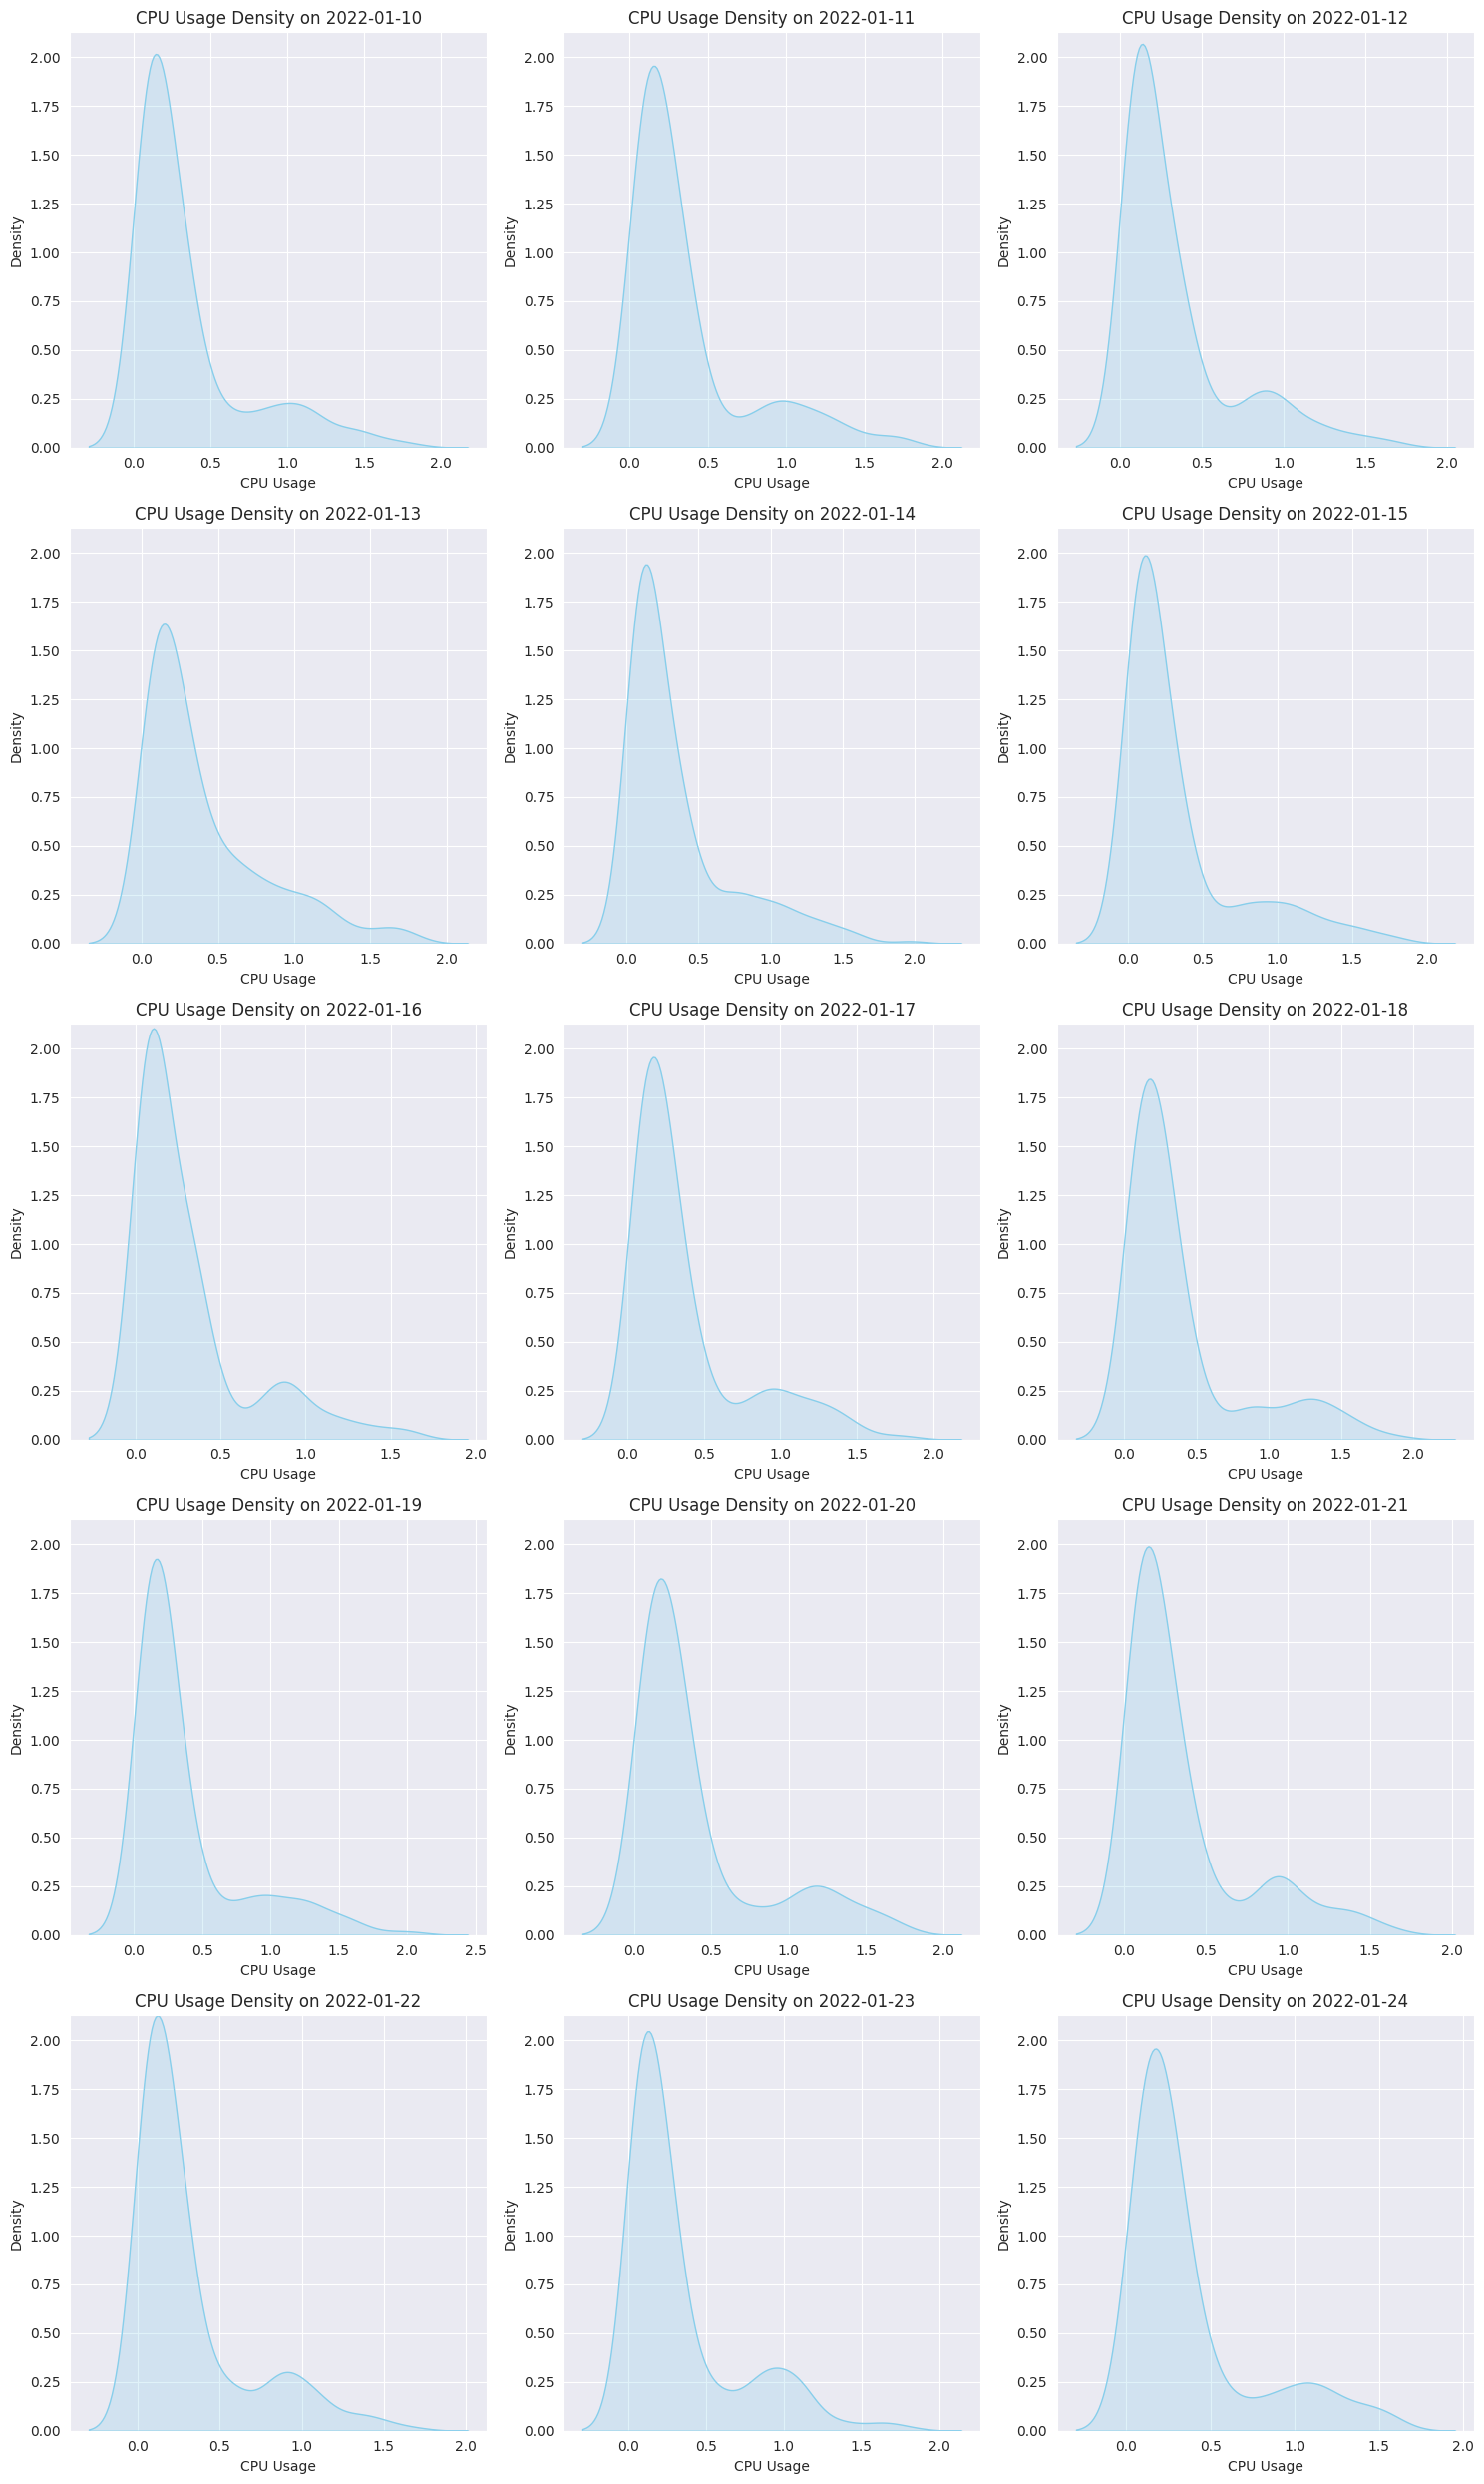

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

groups = data.groupby(data.index.date)


plots_per_row = 3

num_plots = len(groups)
num_rows = math.ceil(num_plots / plots_per_row)

all_densities = []
for date, group in groups:
    kde = sns.kdeplot(group['cpu_usage'].dropna()).get_lines()[0].get_data()
    all_densities.append(kde[1])
    plt.clf()

y_min = 0
y_max = max([max(density) for density in all_densities])

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 5), squeeze=False)

for i, (date, group) in enumerate(groups):
    ax = axes.flat[i]
    sns.kdeplot(group['cpu_usage'].dropna(), ax=ax, color='skyblue', fill=True)
    ax.set_title(f'CPU Usage Density on {date}')
    ax.set_xlabel('CPU Usage')
    ax.set_ylabel('Density')
    ax.set_ylim(y_min, y_max)

for ax in axes.flat[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


- Значения `CPU usage` колеблются в диапазоне от ~0.06 до значений выше 1.0 (в отдельных случаях встречаются пики загрузки выше 1.4–1.5).
- Большая часть записей находится ближе к нижнему краю диапазона (~0.07–0.3), что ожидаемо для обычного уровня CPU нагрузки.


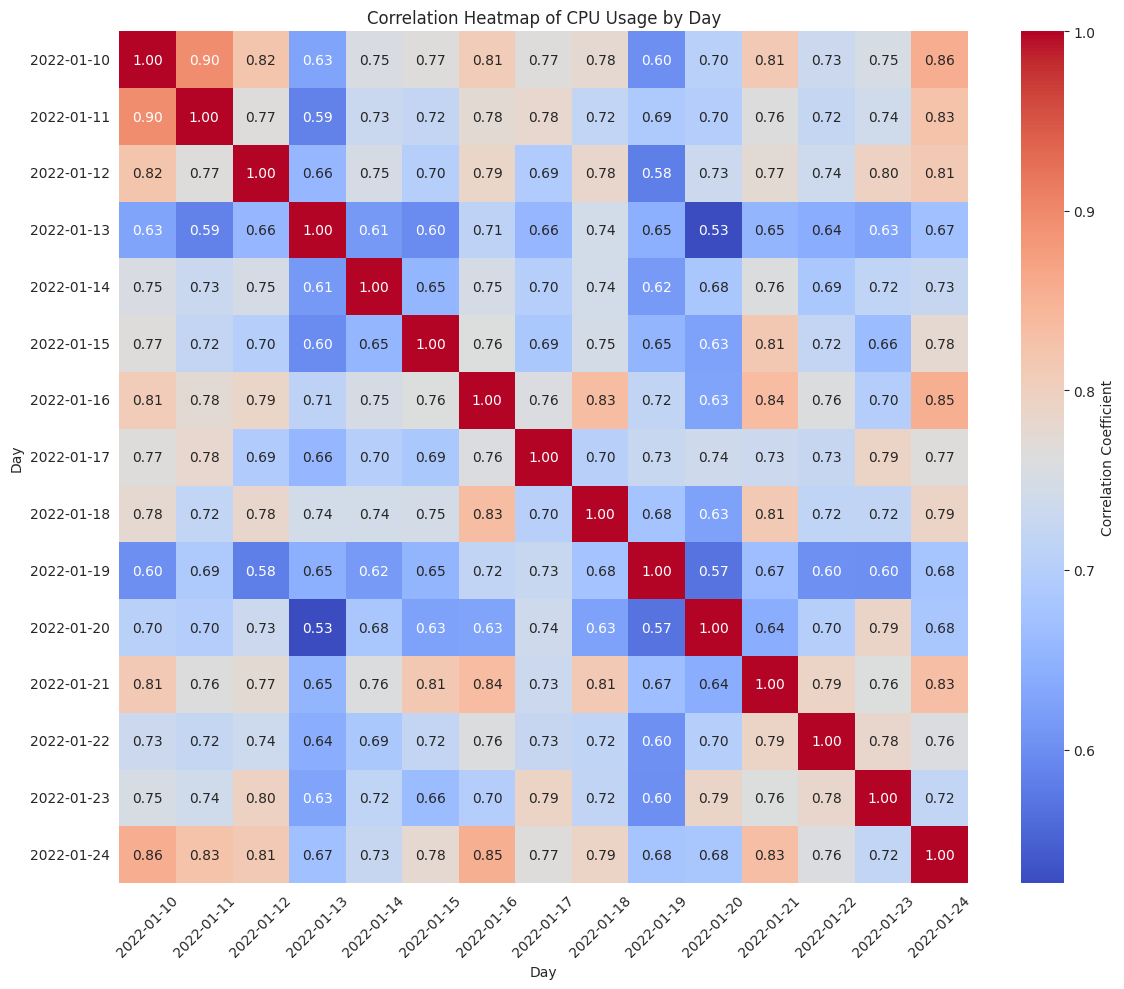

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

filtered_data = data.copy()

filtered_data['date'] = filtered_data.index.date

pivoted_data = filtered_data.pivot_table(index=filtered_data.index.time,
                                         columns='date',
                                         values='cpu_usage')

correlation_matrix = pivoted_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Heatmap of CPU Usage by Day')
plt.xlabel('Day')
plt.ylabel('Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- Матрица корреляций выглядит корректной: значения на интервале [0.53, 0.9] показывают высокую степень схожести загрузки CPU на уровне дневного шаблона.
- Heatmap построен правильно и предоставляет полезный визуальный анализ


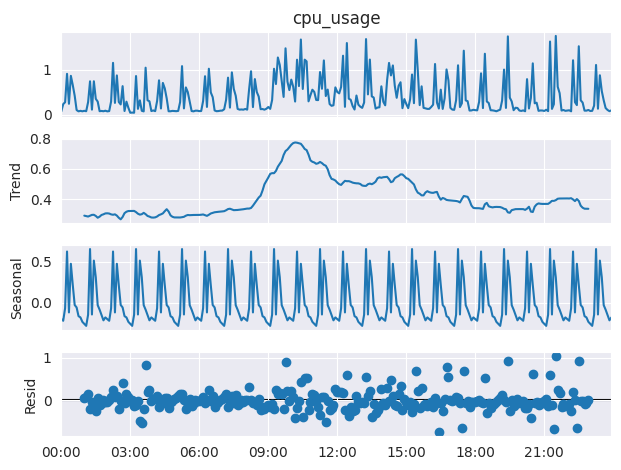

In [13]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import datetime


weekday_data = data[data.index.weekday < 5]
random_weekday = random.choice(weekday_data.index.date)

selected_day_data = weekday_data[weekday_data.index.date == random_weekday]


result = seasonal_decompose(selected_day_data['cpu_usage'].dropna(), model='additive', period=24)
fig = result.plot()

for ax in fig.axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()


Результат разложения временного ряда включает 3 основных компоненты:
1. *Trend (тренд):*
    - Отражает общую долгосрочную тенденцию в данных.
    - Здесь видно, что в данных существует некоторое поступательное нарастание тренда с ярко выраженными переходами (например, рост от 0.3 до больших значений около 0.7-0.8).
    - Возможны пиковые значения в середине данных и снижение ближе к концу (например, до 0.33-0.4).

2. *Seasonal (сезонная компонента):*
    - Обнаружена хорошо выраженная сезонность с периодом, повторяющимся каждые 24 значения (например, от шаблона расчетов).
    - Данные показывают колебания как положительные, так и отрицательные. Вероятно, это повторяющееся ежедневное влияние или циклы.

3. *Residual (остатки):*
    - Остатки содержат вариации, не объясненные трендом или сезонной компонентой.
    - Видно, что есть небольшой "шум", который может отражать нерегулярные колебания или выбросы в данных.


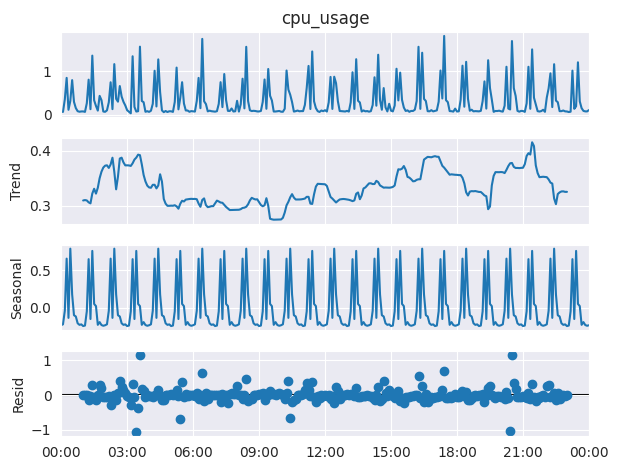

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
import matplotlib.dates as mdates

weekday_data = data[data.index.weekday >= 5]
first_weekday = weekday_data.index.normalize().min()

date_range = (first_weekday, first_weekday + timedelta(hours=24))
selected_data = weekday_data.loc[date_range[0]:date_range[1]]

result = seasonal_decompose(selected_data['cpu_usage'].dropna(), model='additive', period=24)
fig = result.plot()

for ax in fig.axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()


Результат разложения временного ряда включает 3 основных компоненты:
1. Observed (Наблюдаемые данные):
- Этот компонент отображает исходные данные `cpu_usage`, которые были переданы в декомпозицию.
- Наблюдаемая временная серия включает значения, варьирующиеся от очень малых (около *0.06*) до значений около *1.5*.
- Присутствуют сильные колебания разного масштаба, что указывает на наличие закономерностей как краткосрочного, так и долгосрочного характера в данных.

2. Trend (Тренд):
- Трендовый компонент представляет долгосрочную тенденцию. Значение тренда изменяется достаточно плавно.
- Минимальное значение замечено около *0.27*, а максимальные значения — выше *0.4*, что указывает на небольшие долгосрочные изменения.
- Отмечается, что тренд достаточно сглажен, что логично, учитывая, что он предназначен для устранения быстрых колебаний и выделения только структурных изменений в данных.

3. Seasonal (Сезонность):
- Сезонная компонента построена на периодичности данных. В данном случае она имеет колебания в диапазоне:
    - Максимум: *+0.79*
    - Минимум: *-0.24*


# ML

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['cpu_usage']])


def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)


X, y = create_sequences(scaled_data)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [17]:
def create_features(df, label=None):
    """
    Generate additional features from the datetime index. Assumes 'df' has a DateTimeIndex and a single numeric column.
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour

    X = df[['hour']]

    if label:
        y = df[label]
        return X, y
    return X

def mean_absolute_percentage_error(y_true, y_pred):

  """ MAPE """

  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def error_metrics(y_true, y_pred):
    """ Подсчёт метрик и вывод на экран """
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    print('Mean Squared Error: {:.8f}'.format(MSE))
    print('Root Mean Squared Error: {:.8f}'.format(RMSE))
    print('Mean Absolute Error: {:.8f}'.format(MAE))
    print('Mean Absolute Percentage Error: {:.8f} %'.format(MAPE))

    return MSE, RMSE, MAE, MAPE

train = data.iloc[:split].copy()
test = data.iloc[split:].copy()


# Baseline

In [18]:
new_features_train = create_features(train)
df_groupby_train = train.groupby(["hour"])["cpu_usage"].mean()
new_features_test = create_features(test)
df_groupby_test = test.groupby(["hour"])["cpu_usage"].mean()

In [19]:
baseline_MSE, baseline_RMSE, baseline_MAE, baseline_MAPE = error_metrics(df_groupby_train, df_groupby_test)

Mean Squared Error: 0.00079932
Root Mean Squared Error: 0.02827229
Mean Absolute Error: 0.02319272
Mean Absolute Percentage Error: 6.29205105 %


# LinearRegression

In [20]:
from sklearn.linear_model import LinearRegression

X_train_lin = X_train.reshape(X_train.shape[0], -1)
X_test_lin = X_test.reshape(X_test.shape[0], -1)

linear_model = LinearRegression()
linear_model.fit(X_train_lin, y_train)
y_pred_lin = linear_model.predict(X_test_lin)

linear_MSE, linear_RMSE, linear_MAE, linear_MAPE = error_metrics(y_test, y_pred_lin)


Mean Squared Error: 0.01914185
Root Mean Squared Error: 0.13835406
Mean Absolute Error: 0.10835681
Mean Absolute Percentage Error: 194.73267944 %


# RandomForest

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_lin, y_train)
y_pred_rf = rf_model.predict(X_test_lin)

rf_MSE, rf_RMSE, rf_MAE, rf_MAPE = error_metrics(y_test, y_pred_rf)

Mean Squared Error: 0.00691495
Root Mean Squared Error: 0.08315618
Mean Absolute Error: 0.05034133
Mean Absolute Percentage Error: 64.65253465 %


# SVR

In [22]:
from sklearn.svm import SVR

svr_model = SVR()
svr_model.fit(X_train_lin, y_train)
y_pred_svm = svr_model.predict(X_test_lin)

svr_MSE, svr_RMSE, svr_MAE, svr_MAPE = error_metrics(y_test, y_pred_svm)


Mean Squared Error: 0.00946381
Root Mean Squared Error: 0.09728210
Mean Absolute Error: 0.07204326
Mean Absolute Percentage Error: 144.91799215 %


# KNeighbors

In [23]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_lin, y_train)
y_pred_knn = knn_model.predict(X_test_lin)

knr_MSE, knr_RMSE, knr_MAE, knr_MAPE = error_metrics(y_test, y_pred_knn)


Mean Squared Error: 0.00797592
Root Mean Squared Error: 0.08930799
Mean Absolute Error: 0.05166867
Mean Absolute Percentage Error: 56.11395917 %


In [24]:
import pandas as pd
mse_values = {
    'Model': ['Baseline', 'Linear', 'Random Forest', 'SVM', 'k-NN'],
    'MSE': [baseline_MSE, linear_MSE, rf_MSE, svr_MSE, knr_MSE],
    'RMSE': [baseline_RMSE, linear_RMSE, rf_RMSE, svr_RMSE, knr_RMSE],
    'MAE': [baseline_MAE, linear_MAE, rf_MAE, svr_MAE, knr_MAE],
    'MAPE': [baseline_MAPE, linear_MAPE, rf_MAPE, svr_MAPE, knr_MAPE],
}

comparison_df = pd.DataFrame(mse_values)

comparison_df.set_index('Model', inplace=True)

print(comparison_df)


                    MSE      RMSE       MAE        MAPE
Model                                                  
Baseline       0.000799  0.028272  0.023193    6.292051
Linear         0.019142  0.138354  0.108357  194.732679
Random Forest  0.006915  0.083156  0.050341   64.652535
SVM            0.009464  0.097282  0.072043  144.917992
k-NN           0.007976  0.089308  0.051669   56.113959


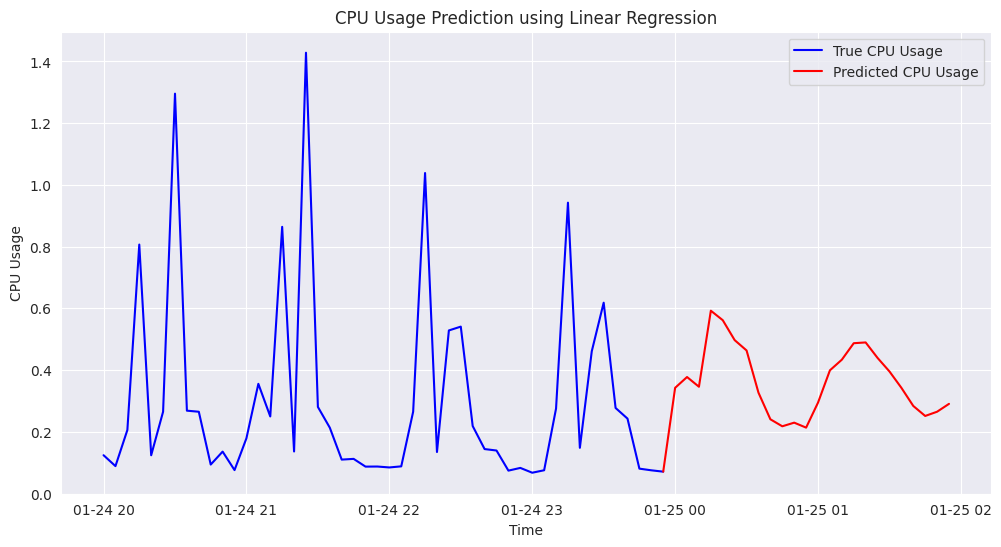

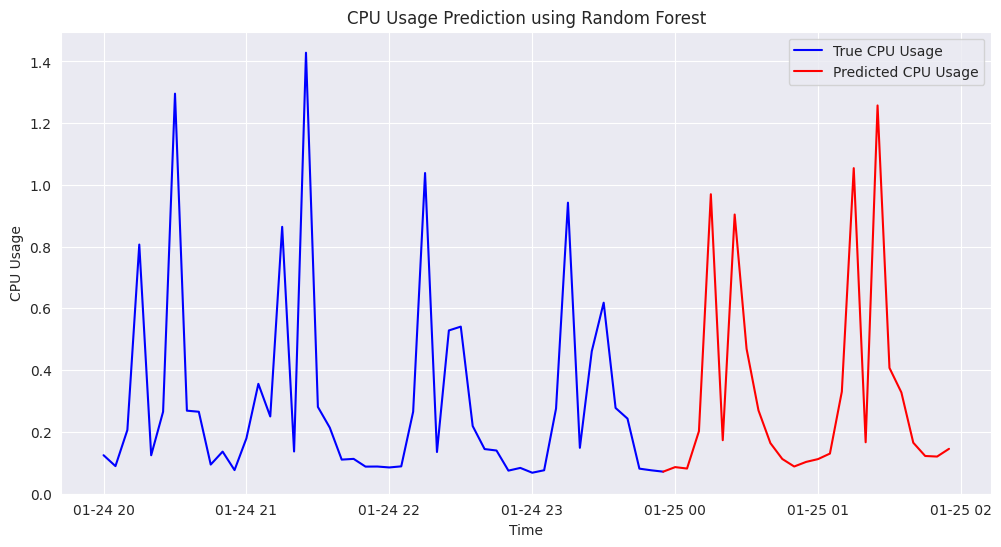

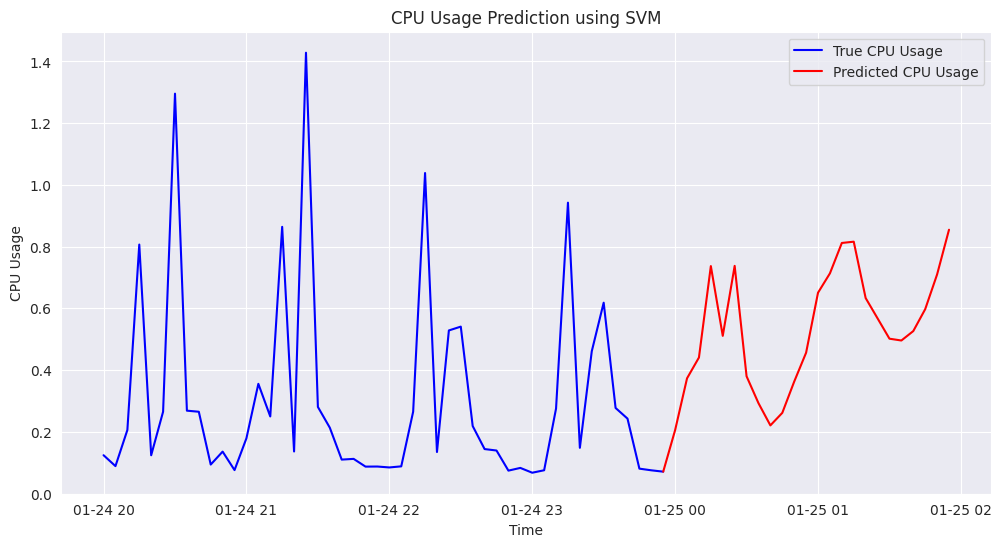

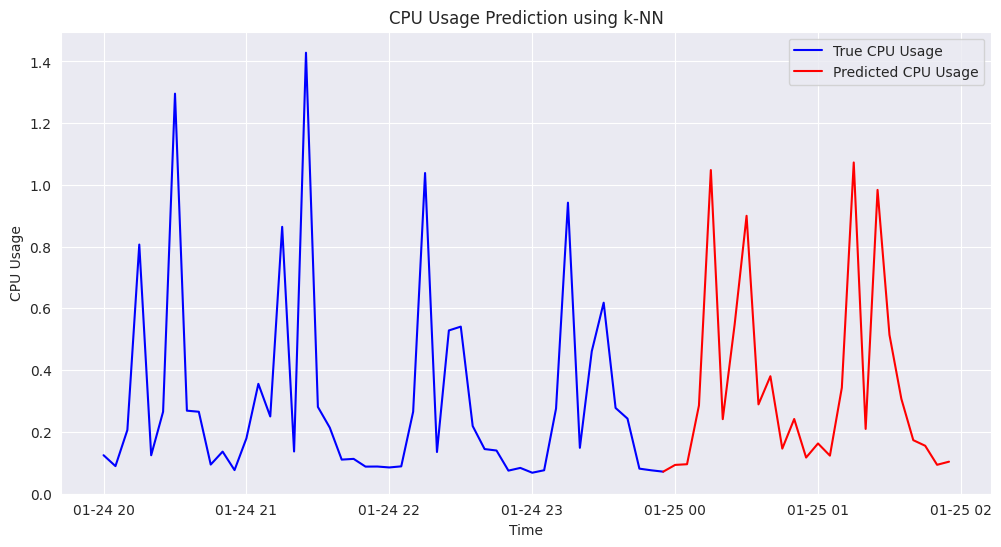

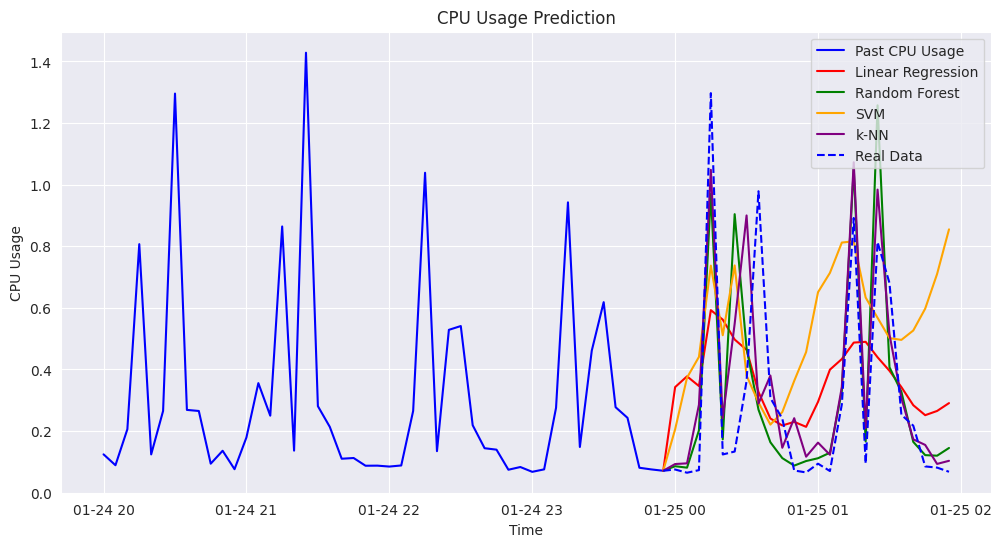

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['cpu_usage']])


def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)


X, y = create_sequences(scaled_data)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

def predict_with_model(model, X_train, y_train, X_last):
    model.fit(X_train, y_train)
    predictions = []
    input_data = X_last.copy()

    for _ in range(24):  # Predict the next 24 steps
        pred = model.predict(input_data.reshape(1, -1))[0]
        predictions.append(pred)
        input_data = np.append(input_data[1:], pred)
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

last_sequence = scaled_data[-10:].flatten()

future_cpu_linear = predict_with_model(linear_model, X_train_flat, y_train, last_sequence)
future_cpu_rf = predict_with_model(rf_model, X_train_flat, y_train, last_sequence)
future_cpu_svr = predict_with_model(svr_model, X_train_flat, y_train, last_sequence)
future_cpu_knn = predict_with_model(knn_model, X_train_flat, y_train, last_sequence)

past_48_hours_scaled = scaled_data[-48:].flatten()
past_48_hours = data.index[-48:]

def plot_future_predictions(model_name, future_cpu_usage):
    plt.figure(figsize=(12, 6))
    plt.plot(past_48_hours, scaler.inverse_transform(past_48_hours_scaled.reshape(-1, 1)), label='True CPU Usage',              color='blue')
    plt.plot(pd.date_range(data.index[-1], periods=25, freq='5min'), np.append(data['cpu_usage'].iloc[-1], future_cpu_usage), label='Predicted CPU Usage', color='red')
    plt.title(f'CPU Usage Prediction using {model_name}')
    plt.ylabel('CPU Usage')
    plt.xlabel('Time')
    plt.legend(loc='upper right')
    plt.show()


plot_future_predictions('Linear Regression', future_cpu_linear)
plot_future_predictions('Random Forest', future_cpu_rf)
plot_future_predictions('SVM', future_cpu_svr)
plot_future_predictions('k-NN', future_cpu_knn)


plt.figure(figsize=(12, 6))

plt.plot(past_48_hours, scaler.inverse_transform(past_48_hours_scaled.reshape(-1, 1)),
         label='Past CPU Usage', color='blue')

plt.plot(pd.date_range(data.index[-1], periods=25, freq='5min'),
         np.append(data['cpu_usage'].iloc[-1], future_cpu_linear),
         label='Linear Regression', color='red')

plt.plot(pd.date_range(data.index[-1], periods=25, freq='5min'),
         np.append(data['cpu_usage'].iloc[-1], future_cpu_rf),
         label='Random Forest', color='green')

plt.plot(pd.date_range(data.index[-1], periods=25, freq='5min'),
         np.append(data['cpu_usage'].iloc[-1], future_cpu_svr),
         label='SVM', color='orange')

plt.plot(pd.date_range(data.index[-1], periods=25, freq='5min'),
         np.append(data['cpu_usage'].iloc[-1], future_cpu_knn),
         label='k-NN', color='purple')

plt.plot(pd.date_range(data.index[-1], periods=25, freq='5min'),
         np.append(data['cpu_usage'].iloc[-1], last_day['cpu_usage'].to_numpy()[:24]),
         label='Real Data', color='blue', linestyle='dashed')

plt.title('CPU Usage Prediction')
plt.ylabel('CPU Usage')
plt.xlabel('Time')
plt.legend(loc='upper right')
plt.show()


# NN (GRU, RNN, LSTM)

In [27]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Constants
LAST_HOURS = -48
TIME_STEPS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 200
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1
INPUT_SIZE = 1
DROPOUT = 0.3

def normalize_data(column_data):
    """Normalizes a single column of data using MinMaxScaler."""
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(column_data), scaler


def create_sequences(data, time_steps):
    """Generates sequences and corresponding labels from the input data."""
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)


def prepare_dataloader(X, y, batch_size, shuffle=False):
    """Converts data into PyTorch DataLoader."""
    X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, TIME_STEPS, INPUT_SIZE)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, OUTPUT_SIZE)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


class TimeSeriesModel(nn.Module):
    def __init__(self, model_type, input_size, hidden_size, num_layers, output_size, dropout):
        super(TimeSeriesModel, self).__init__()
        self.model_type = model_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True  # Make the models bidirectional
        self.num_directions = 2 if self.bidirectional else 1

        if model_type == 'RNN':
            self.model = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,
                                bidirectional=self.bidirectional, dropout=dropout)
        elif model_type == 'LSTM':
            self.model = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                                 bidirectional=self.bidirectional, dropout=dropout)
        elif model_type == 'GRU':
            self.model = nn.GRU(input_size, hidden_size, num_layers, batch_first=True,
                                bidirectional=self.bidirectional, dropout=dropout)

        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_size * self.num_directions, output_size)
        )

        self._initialize_weights()

    def forward(self, x):
        batch_size = x.size(0)

        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size)
        if self.model_type == "LSTM":
            c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size)
            out, _ = self.model(x, (h0, c0))
        else:
            out, _ = self.model(x, h0)

        out = self.fc(out[:, -1, :])
        return out

    def _initialize_weights(self):
        """Weight initialization to stabilize learning."""
        for name, param in self.model.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)


def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, scheduler):
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience = 10
    counter = 0

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)

            loss = criterion(output, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in test_loader:
                y_pred = model(X_val)
                val_loss += criterion(y_pred, y_val).item()
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    return train_losses, val_losses


def evaluate_and_predict(model, input_seq, scaler, prediction_steps=24):
    input_seq = torch.tensor(input_seq, dtype=torch.float32).view(1, TIME_STEPS, INPUT_SIZE)
    model.eval()
    predictions = []

    with torch.no_grad():
        for _ in range(prediction_steps):
            output = model(input_seq)
            prediction = output.item()
            predictions.append(prediction)

            prediction_tensor = torch.tensor([[prediction]], dtype=torch.float32).unsqueeze(-1)
            input_seq = torch.cat((input_seq[:, 1:, :], prediction_tensor), dim=1)

    predictions_clipped = np.clip(np.array(predictions), 0, 1)
    return scaler.inverse_transform(predictions_clipped.reshape(-1, 1)).flatten()


scaled_data, scaler = normalize_data(data[['cpu_usage']])
X, y = create_sequences(scaled_data, TIME_STEPS)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
train_loader = prepare_dataloader(X_train, y_train, BATCH_SIZE, shuffle=True)
test_loader = prepare_dataloader(X_test, y_test, BATCH_SIZE, shuffle=False)

criterion = nn.MSELoss()

rnn_model = TimeSeriesModel('RNN', INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)
rnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(rnn_optimizer, mode='min', patience=10, factor=0.1)
rnn_train_losses, rnn_val_losses = train_model(rnn_model, train_loader, test_loader, criterion, rnn_optimizer, EPOCHS,
                                               rnn_scheduler)
future_rnn_predictions = evaluate_and_predict(rnn_model, X[-1], scaler)

lstm_model = TimeSeriesModel('LSTM', INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(lstm_optimizer, mode='min', patience=10, factor=0.1)
lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, test_loader, criterion, lstm_optimizer,
                                                 EPOCHS, lstm_scheduler)
future_lstm_predictions = evaluate_and_predict(lstm_model, X[-1], scaler)

gru_model = TimeSeriesModel('GRU', INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
gru_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gru_optimizer, mode='min', patience=10, factor=0.1)
gru_train_losses, gru_val_losses = train_model(gru_model, train_loader, test_loader, criterion, gru_optimizer, EPOCHS,
                                               gru_scheduler)
future_gru_predictions = evaluate_and_predict(gru_model, X[-1], scaler)

Epoch 1/200 - Train Loss: 0.0237 - Validation Loss: 0.0094
Epoch 2/200 - Train Loss: 0.0115 - Validation Loss: 0.0076
Epoch 3/200 - Train Loss: 0.0096 - Validation Loss: 0.0071
Epoch 4/200 - Train Loss: 0.0092 - Validation Loss: 0.0070
Epoch 5/200 - Train Loss: 0.0096 - Validation Loss: 0.0069
Epoch 6/200 - Train Loss: 0.0089 - Validation Loss: 0.0068
Epoch 7/200 - Train Loss: 0.0089 - Validation Loss: 0.0064
Epoch 8/200 - Train Loss: 0.0083 - Validation Loss: 0.0071
Epoch 9/200 - Train Loss: 0.0086 - Validation Loss: 0.0066
Epoch 10/200 - Train Loss: 0.0084 - Validation Loss: 0.0072
Epoch 11/200 - Train Loss: 0.0084 - Validation Loss: 0.0064
Epoch 12/200 - Train Loss: 0.0084 - Validation Loss: 0.0065
Epoch 13/200 - Train Loss: 0.0083 - Validation Loss: 0.0066
Epoch 14/200 - Train Loss: 0.0095 - Validation Loss: 0.0076
Epoch 15/200 - Train Loss: 0.0090 - Validation Loss: 0.0067
Epoch 16/200 - Train Loss: 0.0083 - Validation Loss: 0.0065
Epoch 17/200 - Train Loss: 0.0080 - Validation Lo

In [49]:
def plot_predictions(real_data, predicted_data_rnn, predicted_data_lstm, predicted_data_gru, scaler):
    plt.figure(figsize=(12, 6))

    real_values = scaler.inverse_transform(real_data.to_numpy().reshape(-1, 1))
    plt.plot(real_data.index[LAST_HOURS:], real_values,
             label='True CPU Usage', color='blue')

    prediction_times = pd.date_range(real_data.index[-1], periods=len(predicted_data_rnn) + 1, freq='5min')

    plt.plot(prediction_times,
             np.concatenate(([real_values[-1][0]], predicted_data_rnn)),
             label='RNN Predictions', color='red', linestyle='--')

    plt.plot(prediction_times,
             np.concatenate(([real_values[-1][0]], predicted_data_lstm)),
             label='LSTM Predictions', color='green', linestyle='--')

    plt.plot(prediction_times,
             np.concatenate(([real_values[-1][0]], predicted_data_gru)),
             label='GRU Predictions', color='yellow', linestyle='--')

    plt.plot(prediction_times,
             np.concatenate(([real_values[-1][0]], last_day['cpu_usage'].to_numpy()[:24])),
             label='Real Data', color='blue', linestyle='--')

    plt.title(f'RNN, LSTM and GRU CPU Usage Predictions')
    plt.ylabel('CPU Usage')
    plt.xlabel('Time')
    plt.legend(loc='upper right')
    plt.show()



def plot_training_losses(train_losses, val_losses, model_name):
    """Plots training and validation losses for a given model."""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title(f"Training and Validation Loss for {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def compute_metrics(model, data_loader, scaler):
    y_pred, y_true = [], []

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            output = model(X_batch)

            y_pred.extend(output.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
    y_true = scaler.inverse_transform(np.array(y_true).reshape(-1, 1))

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mse, rmse, mae, mape

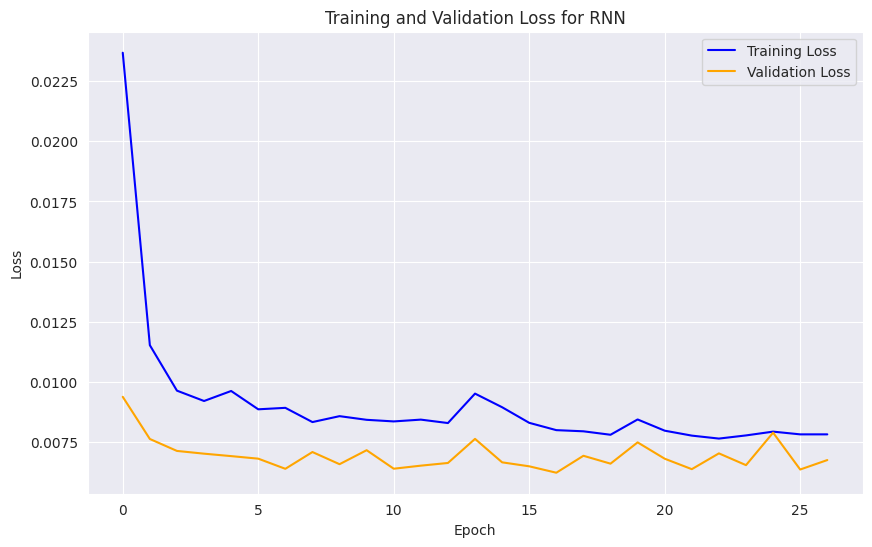

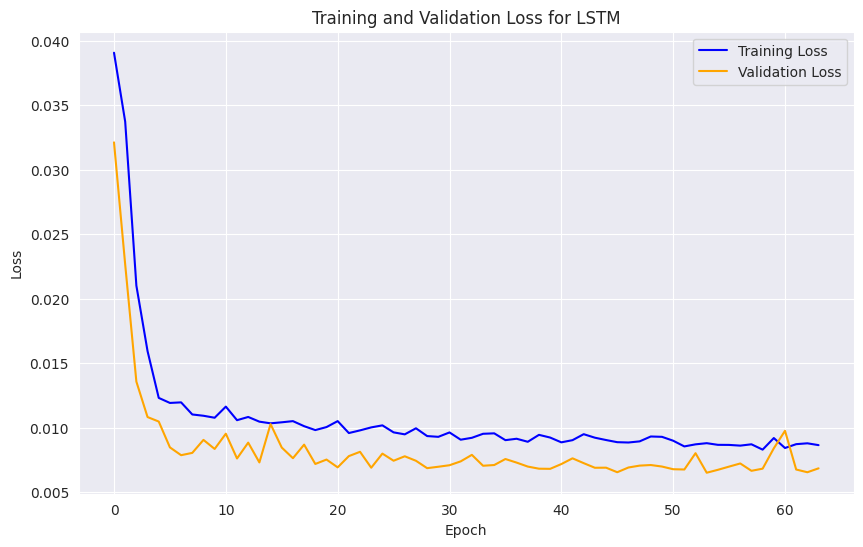

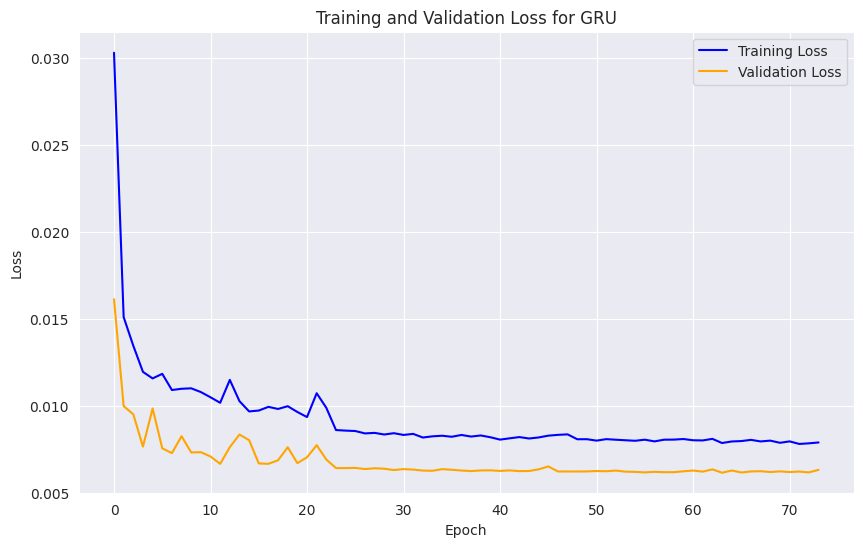

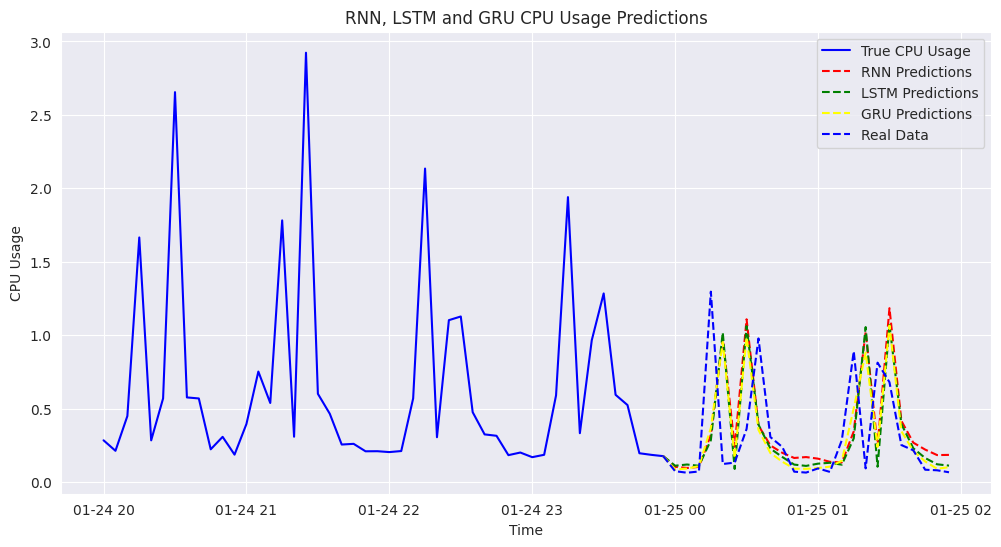

In [50]:
plot_training_losses(rnn_train_losses, rnn_val_losses, "RNN")
plot_training_losses(lstm_train_losses, lstm_val_losses, "LSTM")
plot_training_losses(gru_train_losses, gru_val_losses, "GRU")

plot_predictions(data[LAST_HOURS:], future_rnn_predictions, future_lstm_predictions, future_gru_predictions, scaler)

In [37]:
rnn_MSE, rnn_RMSE, rnn_MAE, rnn_MAPE = compute_metrics(rnn_model, test_loader, scaler)
lstm_MSE, lstm_RMSE, lstm_MAE, lstm_MAPE = compute_metrics(lstm_model, test_loader, scaler)
gru_MSE, gru_RMSE, gru_MAE, gru_MAPE = compute_metrics(gru_model, test_loader, scaler)


In [32]:
mse_comparison = pd.DataFrame({
    'Model': ['RNN', 'LSTM', 'GRU'],
    'MSE': [rnn_MSE, lstm_MSE, gru_MSE],
    'RMSE': [rnn_RMSE, lstm_RMSE, gru_RMSE],
    'MAE': [rnn_MAE, lstm_MAE, gru_MAE],
    'MAPE': [rnn_MAPE, lstm_MAPE, gru_MAPE]
})

mse_comparison.set_index('Model', inplace=True)

print(mse_comparison)

            MSE      RMSE       MAE       MAPE
Model                                         
RNN    0.027593  0.166113  0.100283  46.144950
LSTM   0.027777  0.166663  0.097503  40.842631
GRU    0.025994  0.161227  0.089747  33.350554


In [33]:
combined_df = pd.concat([mse_comparison, comparison_df], axis=0)
print(combined_df)

                    MSE      RMSE       MAE        MAPE
Model                                                  
RNN            0.027593  0.166113  0.100283   46.144950
LSTM           0.027777  0.166663  0.097503   40.842631
GRU            0.025994  0.161227  0.089747   33.350554
Baseline       0.000799  0.028272  0.023193    6.292051
Linear         0.019142  0.138354  0.108357  194.732679
Random Forest  0.006915  0.083156  0.050341   64.652535
SVM            0.009464  0.097282  0.072043  144.917992
k-NN           0.007976  0.089308  0.051669   56.113959
